# INFO 3350/6350

## Lecture 07: Model inspection and explainability

## Explaining your model

### What does it mean to "explain" a model?

**Can you tell someone else (or yourself!) how it works?** It's more than just the algorithm, though understanding the algorithm is part of it ...

* What are your inputs?
* Where do your data come from?
* What algorithm did you use?
* How did you select your parameters (for preprocessing, algorithm selection, hyperparameters, etc.)
* How accurate are your results?
* On what kinds of objects does the model perform well or badly?
* What features most impact classification accuracy?
    * Overall?
    * For any given object?

### Why is explainability important?

In general:

* Can you convince someone (or yourself) that your model is trustworthy?
* Are there errors or anomalies in your data/processing/code?
    * Consider a British/American text classifier that uses frequency of "colour" or "lorry"
    * Or a news article topic classifier that includes source names like "The Wall Street Journal" or "The Sporting News" in its input
        * Not wrong, but fragile, not generalizable
* When the classifier makes mistakes, why did it fail?
* Is your classifer biased?
    * Are the features driving your model ones that you trust? Or that you *should* use?
    * Consider ZIP code or prior arrest for predicting recidivism
    
In some cases:

* Maybe you care about the features
    * Consider medical treatment. Give five drugs, which ones drive recovery?
* Maybe the features help you understand the (high-level) phenomenon you're modeling
    * For example, authorship attribution via stopword frquency

### Must you care about explaining your model?

* Probably, but sometimes more than others
* Things that decrease the need for explainability:
    * You only care about accuracy/performance
    * You will only ever work with one dataset
        * And you have high confidence in its quality
    * The stakes of your classification are low
        * No one is harmed if/when you're wrong
    * The costs of modeling are low (so that you don't need to justify your existence to a funder)
* This is all to say: **If your problem is important, explainability is important**
    
## Types of explanation

### Intrinsic and model-specific

* Does your model produce individual feature weights or decision criteria?
    * Linear models, trees
* Do you know in advance which model(s) you'll use?
    * Recall we noted that decision trees are popular because they are so easily interpretable, even when they rarely offer best performance

### *Post hoc* and model-agnostic

* Is your model a "black box"?
    * Ensembles, neural networks
* Do you want to be able to use/interpret/explain an arbitrary classifier?

### Local or global?

* Do you need to identify the most important features overall? (global)
* Do you need to be able to identify the most important features for an individual classification? (local)

## Some approaches

### Linear methods

* Examples: Logistic regression, Lasso, Ridge
* Intrinsic, global
* Many `sklearn` classifiers have a `.coef_` attribute of the trained classifer object. 
* This provides the coefficients of each feature in the input matrix.

### Trees

* Example: Decison tree, Random forest (by extension)
* Intrinsic, global
* Has an attribute `feature_importances_`
* Reflects the degree to which each feature separates the classes
    * "How much does selecting on a feature reduce the impurity of the classes?"

### Permutation

* Can be used with black box models
* Is *post hoc*
* Note that this is one version of what we mentioned in the previous lecture when we mentioned *post hoc* feature selection
* In brief:
    * Measure model performance (accuracy, f1, etc.)
    * Shuffle (permute) the values of one feature for all the objects 
        * This renders the feature non-informative
    * Measure model performance again
        * It will drop, unless the feature was non-informative to begin with (in which case, it'll stay about the same)
    * Repeat for all features
    * The features that, when shuffled, produce the largest drop in classification performance are the most important ones
* Note that permutation in this case shouldn't be confused with a permutation test as used to estimate the *p* value for a hypothesis test (you should remember the latter from 2950).

### Partial dependence

* Often most useful for regression, but can be adapted to classification
* Asks: by how much does the response variable change when I make a small change to the input variable across a range of possible input values?
    * For classification, need to measure something like the change in class probability
    * Note that some `sklearn` classifiers (including `RandomForestClassifier` and `LogisticRegression`) include a `.predict_proba()` method to predict probabilities
        * Output of `predict_proba` is a vector of class probabilities rather than a single (most likely) class label for each object
* Can help to identify non-linear relationships between input and reponse
    * For example, bike rentals are a function of temperature (among other things)
    * Rentals go up with increasing temperature ...
    * ... until it becomes too hot (at which point they decrease with temperature)
* Not often super useful for token-based work, but can be more relevant for embeddings and other dimension-reduced representations

## Packages 

* Scikit-learn
    * [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
    * [sklearn.inspection.partial_dependence](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py)
* [lime](https://github.com/marcotcr/lime)
* [ELI5](https://eli5.readthedocs.io/en/latest/overview.html)
* [SHAP](https://shap.readthedocs.io/en/latest/)

## News demo

About 125,000 news articles, distributed evenly across four categories (world, business, sports, and science/technology), each trimmed to contain **just the first sentence or two of the original article**. [Data source](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv), plus minor massaging into current format.

This is the same dataset we used to discuss feature selection.

### Read and clean news data

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.feature_selection import mutual_info_classif, SelectKBest
from   sklearn.linear_model import LogisticRegressionCV # NB. CV version; autotune hyperparameters
from   sklearn.metrics import classification_report
from   sklearn.model_selection import train_test_split

In [2]:
# read data from disk and examine

news = pd.read_csv(os.path.join('..', 'data', 'news', 'news_text.csv.gz'))

# a function to get rid of datelines at the start of articles
#  matches one or more hyphens or colons in first 40 chars,
#  drops everything before that match (plus the match itself)
pattern = '[-:]+ '
matcher = re.compile(pattern) # compiled regexs are faster

def remove_dateline(text, matcher=matcher):
    '''
    Remove source names and datelines from a text string
    If there is a hyphen or colon in the first 40 characters, 
      drops everything before the hyphen(s)/colon(s)
    If no hyphen/colon, do nothing
    Return processed string
    '''
    result = matcher.search(text, endpos=40)
    if result:
        return text[result.end():]
    else:
        return text

# clean article text
news['body'] = news['body'].apply(remove_dateline)

### Compute token counts

In [3]:
# set up a vectorizer object
count_vectorizer = CountVectorizer(
    strip_accents='unicode', # collapse accents to base character
    stop_words=None, # do not remove stop words
    binary=False, # do not binarize features
    #max_features=1000,
    min_df=0.001 # limit features to those that occur in at least 0.1% of articles
)

# perform vectorization
X = count_vectorizer.fit_transform(news['body'])

# vectorized shape
X.shape

(127600, 3486)

### Classify sports (vs everything else)

We'll use a few different classifiers to demonstrate different approaches to model inspection and explainability ...

In [4]:
news.label.unique()

array(['Sci_Tech', 'Sports', 'Business', 'World'], dtype=object)

In [5]:
news.label.value_counts()

label
Sci_Tech    31900
Sports      31900
Business    31900
World       31900
Name: count, dtype: int64

In [6]:
# make boolean array of sports/other labels
y = news['label'] == 'Sports'

### Train and test on selected examples

In [7]:
# split into train and test sets
# note we retain index positions of articles for later use
# --> limit articles for demo purposes <--
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X[:2000], y[:2000], np.arange(2000))

### Intrinsic examination of logistic regression on selected features

We're really pruning back our features so that the model is easier to inspect.

In [8]:
# Logit using the n most-informative features

# fit selector
n_features = 20
selector = SelectKBest(k=n_features, score_func=mutual_info_classif).fit(X_train, y_train)

# select best features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# fit and predict
clf = LogisticRegressionCV(scoring='f1_weighted', max_iter=500).fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)

# examine performance
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.95      0.87      0.91       412
        True       0.57      0.81      0.67        88

    accuracy                           0.86       500
   macro avg       0.76      0.84      0.79       500
weighted avg       0.89      0.86      0.87       500



In [9]:
# what features have we used?
features_used = count_vectorizer.get_feature_names_out()[[int(i.strip('x')) for i in selector.get_feature_names_out()]]
print(features_used)

['champion' 'company' 'cup' 'football' 'game' 'his' 'inc' 'its' 'league'
 'night' 'play' 'points' 'round' 'said' 'scored' 'season' 'team' 'the'
 'victory' 'win']


#### Examine coefficients

In [10]:
for i in range(clf.coef_.shape[1]):
    print(f"{features_used[i]:<10} {clf.coef_[0,i]:6.3f}")

champion    8.691
company    -4.907
cup         7.277
football    7.274
game        2.948
his         0.801
inc        -4.622
its        -1.922
league      4.258
night       2.093
play        3.426
points      1.946
round       6.732
said       -0.712
scored      5.099
season      2.138
team        2.348
the         0.209
victory     2.721
win         2.939


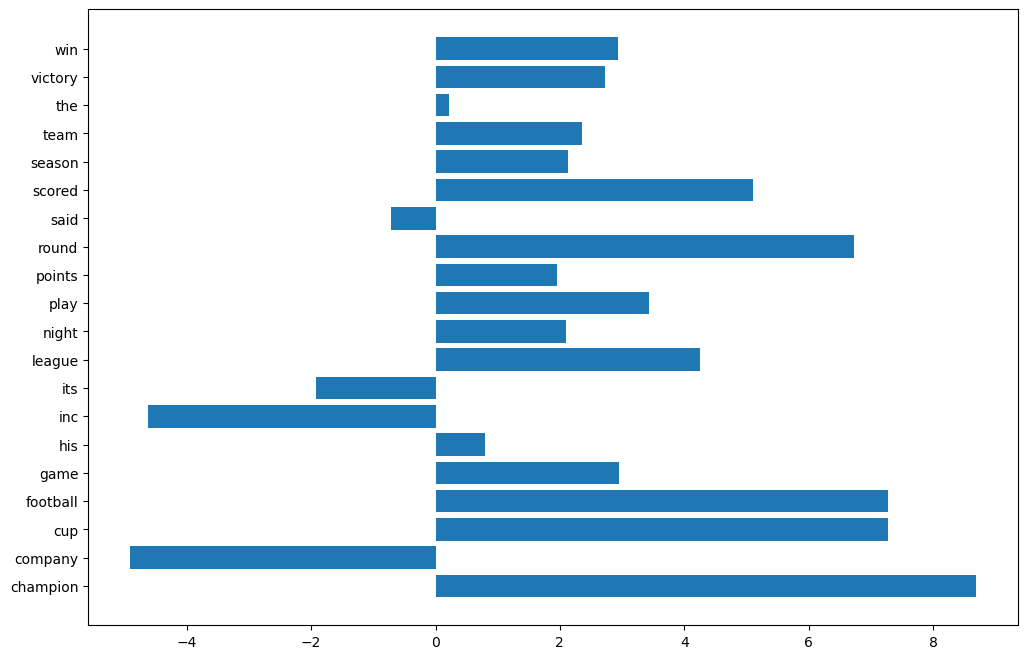

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
plt.barh(list(range(X_train_selected.shape[1])),clf.coef_[0], tick_label=features_used)
plt.show()

### Decision tree feature importance

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_clf = DecisionTreeClassifier(max_features=100, max_depth=30).fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

# examine performance
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.93      0.84      0.88       415
        True       0.46      0.68      0.55        85

    accuracy                           0.81       500
   macro avg       0.70      0.76      0.72       500
weighted avg       0.85      0.81      0.83       500



In [13]:
importance_idx = np.flip(dt_clf.feature_importances_.argsort())

for i in range(20):
    print(f"{count_vectorizer.get_feature_names_out()[importance_idx[i]]:<12} {dt_clf.feature_importances_[importance_idx[i]]:6.3f}")

the           0.040
victory       0.037
league        0.034
series        0.034
round         0.030
boston        0.023
champions     0.022
nfl           0.019
39            0.018
career        0.018
andre         0.017
coach         0.016
was           0.016
medal         0.016
final         0.015
night         0.014
that          0.014
stadium       0.013
cup           0.013
have          0.011


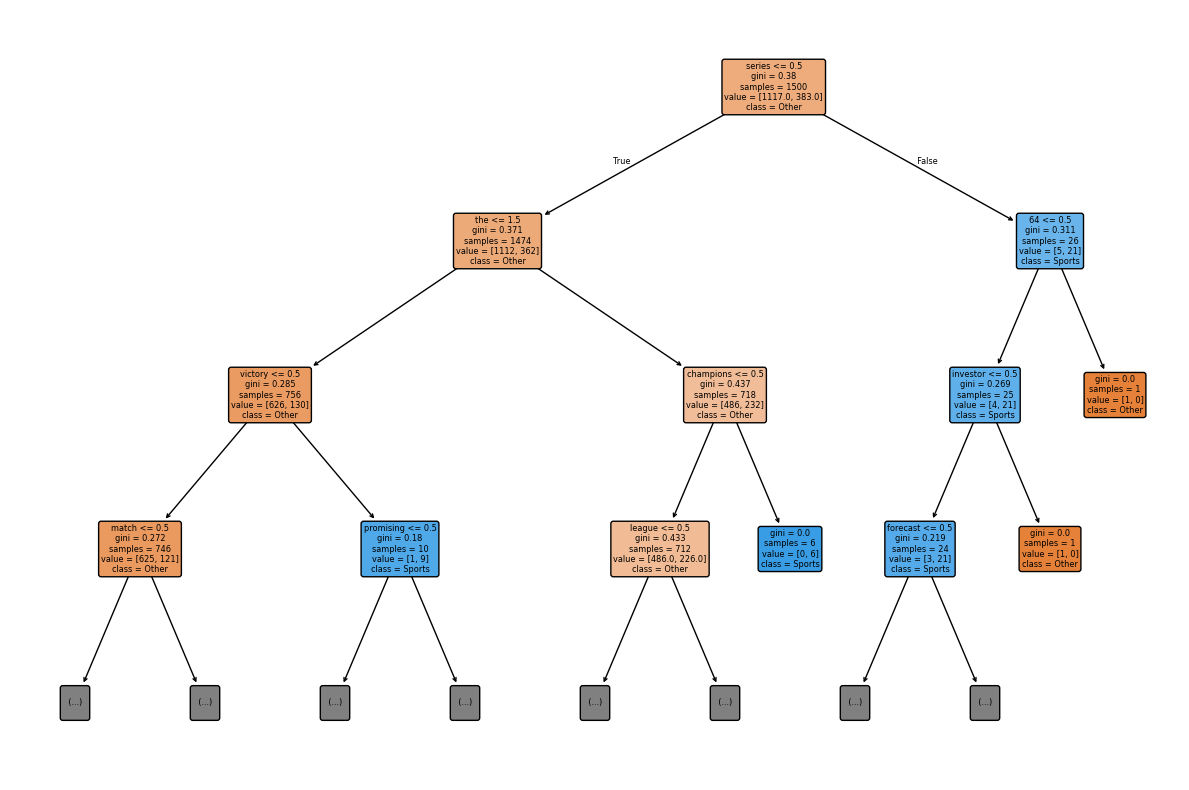

In [14]:
plt.figure(figsize=(12,8))
plot_tree(
    dt_clf, 
    max_depth=3, 
    feature_names=[i for i in count_vectorizer.get_feature_names_out()],
    class_names=['Other', 'Sports'],
    filled=True,
    rounded=True
)
plt.tight_layout()
plt.show()

# Model interpretation with `shap`

A game-theoretical approach to feature model examination. See the [shap documentation](https://github.com/slundberg/shap).

`conda install -c conda-forge shap`

In [15]:
import shap

# build a dataframe for ease of use
df = pd.DataFrame(
    data=X_test_selected.toarray(), 
    columns=features_used,
)
df.head()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,champion,company,cup,football,game,his,inc,its,league,night,play,points,round,said,scored,season,team,the,victory,win
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0


In [16]:
# set up explainer and calculate shap values across multiple resamplings
# note we pass in a *fitted* classifier (here, a LogisticRegression object)
explainer = shap.Explainer(clf, df)
shap_values = explainer(df)

True class: Sports.
Lleyton Hewitt has defeated Olivier Mutis at the \$US380,000 ATP Long Island event to move within one victory of reaching 50 match wins for the fourth time in five years.


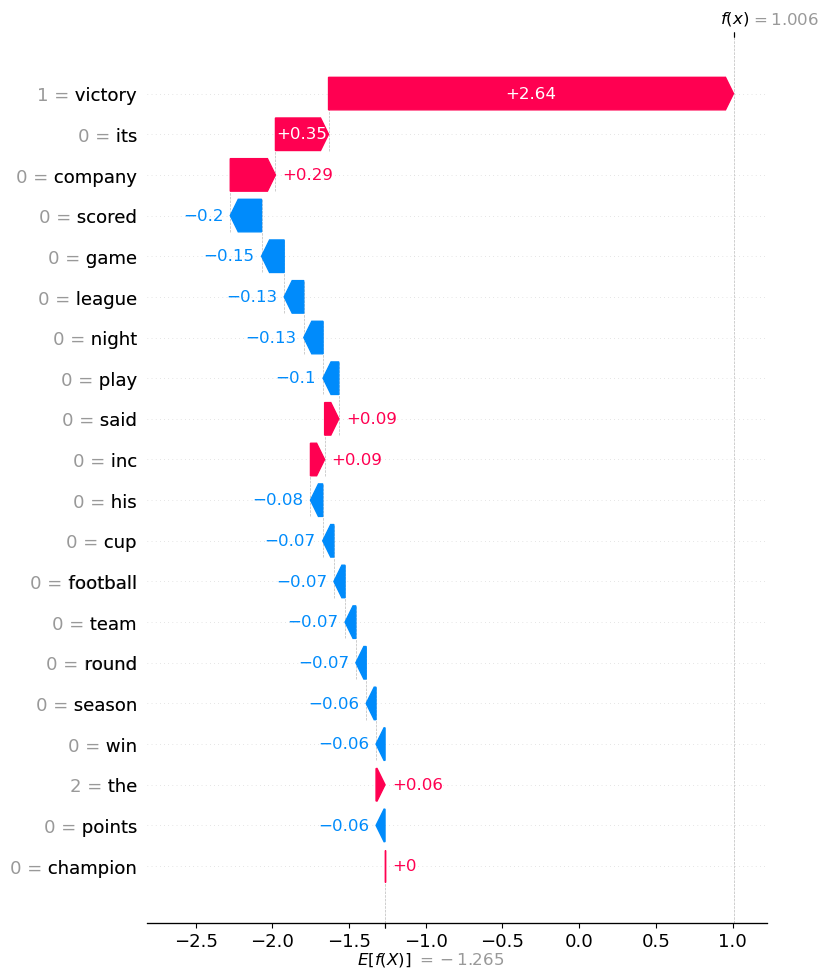

In [17]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_to_explain = 20
print(f"True class: {news.label.iloc[idx_test[sample_to_explain]]}.\n{news.body.iloc[idx_test[sample_to_explain]]}")
shap.plots.waterfall(shap_values[sample_to_explain], max_display=len(df.columns))

In [18]:
# grey numbers in figure are feature values
df.iloc[sample_to_explain]

champion    0
company     0
cup         0
football    0
game        0
his         0
inc         0
its         0
league      0
night       0
play        0
points      0
round       0
said        0
scored      0
season      0
team        0
the         2
victory     1
win         0
Name: 20, dtype: int64

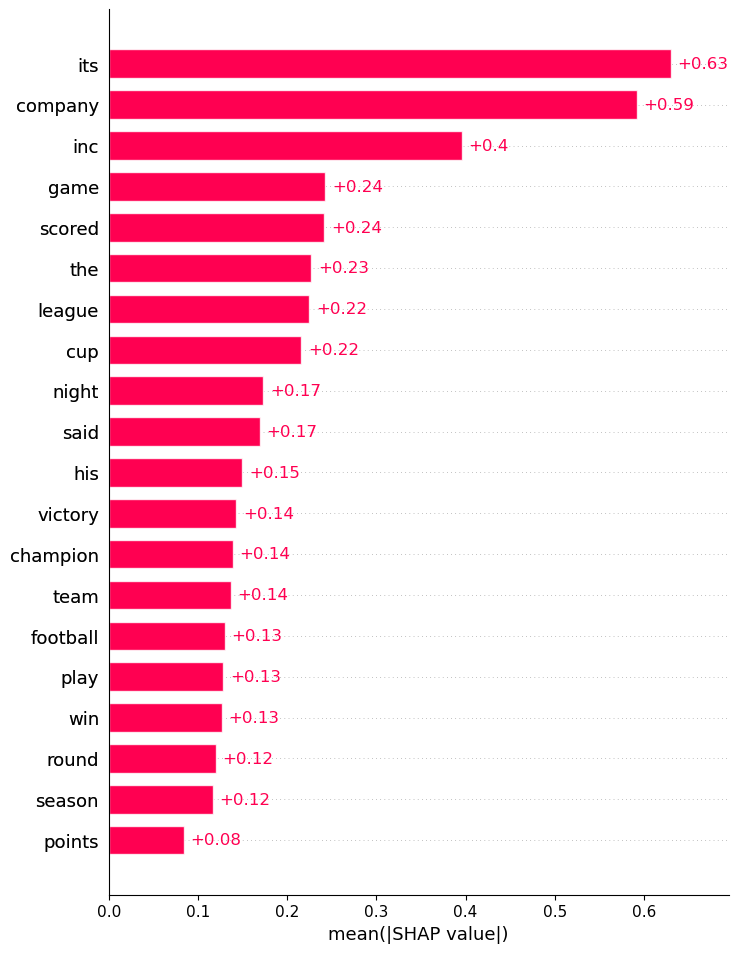

In [19]:
# mean importance for each feature
shap.plots.bar(shap_values, max_display=len(df.columns))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


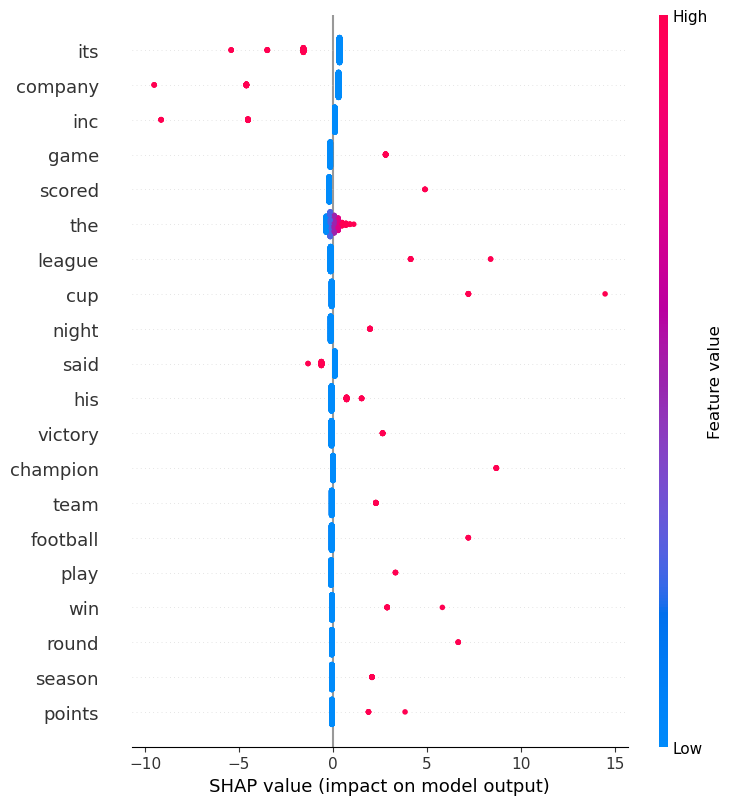

In [20]:
# better yet, distributions over importances for all cases
shap.plots.beeswarm(shap_values, max_display=len(df.columns))